In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

import os
import cv2
import zipfile

from glob import glob
import random

In [2]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d puneet6060/intel-image-classification

401 - Unauthorized


In [4]:
if not os.path.exists('./intel-image-classification/'):
    with zipfile.ZipFile("intel-image-classification.zip","r") as zip_ref:
        zip_ref.extractall("intel-image-classification")

In [5]:
ROOT_PATH = 'intel-image-classification'

config = {

    'TRAIN_PATH': os.path.join(ROOT_PATH, 'seg_train', 'seg_train'),
    'TEST_PATH': os.path.join(ROOT_PATH, 'seg_test', 'seg_test'),
    'VALID_PATH': os.path.join(ROOT_PATH, 'seg_pred', 'seg_pred'),
    'BATCH_SIZE' : 16,
    'IMG_SIZE' : 224
}

classnames=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

train_paths =  glob(os.path.join(config['TRAIN_PATH'], '*', '*'), recursive=True)
test_paths =  glob(os.path.join(config['TEST_PATH'], '*', '*'), recursive=True)

random.shuffle(train_paths)
random.shuffle(test_paths)

In [6]:
def albumentations(img):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=70),
        A.CoarseDropout(p=0.5)
    ])
    
    transformed_image = transform(image=img)['image']
    return transformed_image

def load_data(pathlist, subset, batch_size=config['BATCH_SIZE'], verbose=0):
    X = list()
    y = list()
    
    for index, entry in enumerate(pathlist):
        img = cv2.imread(entry)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (config['IMG_SIZE'], config['IMG_SIZE']))
        label = entry.split(os.sep)[3]

        img = albumentations(img.astype('uint8'))

        X.append(img/255.0)
        y.append(classnames.index(label))
        

    X = np.array(X)
    y = np.array(y)

        
    return X, y

In [7]:
def batch_generator(paths, subset, batch_size = config['BATCH_SIZE']):
    i = 0
    while True:
        if i+batch_size >= len(paths):
            i = 0
        batch = paths[i:i+batch_size]
        i = i+batch_size
        if(len(batch) % batch_size == 0):
            yield load_data(batch, subset, False)

In [8]:
train_generator = batch_generator(train_paths, 'train')
test_generator = batch_generator(test_paths, 'test')

forest


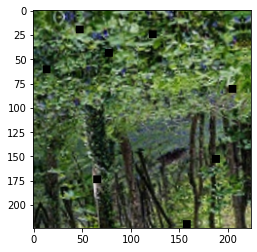

In [9]:
batch = next(train_generator)
plt.imshow(batch[0][0])
print(classnames[batch[1][0]])

street


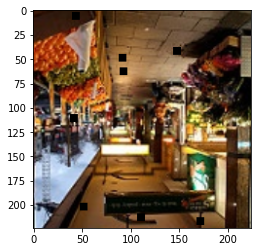

In [10]:
batch = next(test_generator)
plt.imshow(batch[0][0])
print(classnames[batch[1][0]])

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=[224, 224, 3]),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), (2, 2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3, seed=2),
    keras.layers.Dense(6, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',
                       keras.metrics.SparseTopKCategoricalAccuracy(k=2)])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     1

In [13]:
history = model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = len(train_paths)/config['BATCH_SIZE'],
                    validation_steps = len(test_paths)/config['BATCH_SIZE'],
                    epochs = 20)

Epoch 1/20
877/877 [==============================] - 397s 447ms/step - loss: 1.4419 - accuracy: 0.4390 - sparse_top_k_categorical_accuracy: 0.6705 - val_loss: 1.2582 - val_accuracy: 0.4987 - val_sparse_top_k_categorical_accuracy: 0.7204
Epoch 2/20
877/877 [==============================] - 169s 193ms/step - loss: 1.1611 - accuracy: 0.5525 - sparse_top_k_categorical_accuracy: 0.7706 - val_loss: 1.2112 - val_accuracy: 0.5455 - val_sparse_top_k_categorical_accuracy: 0.7666
Epoch 3/20
877/877 [==============================] - 170s 194ms/step - loss: 1.0511 - accuracy: 0.6044 - sparse_top_k_categorical_accuracy: 0.8089 - val_loss: 2.7645 - val_accuracy: 0.2467 - val_sparse_top_k_categorical_accuracy: 0.3976
Epoch 4/20
877/877 [==============================] - 170s 194ms/step - loss: 0.9713 - accuracy: 0.6377 - sparse_top_k_categorical_accuracy: 0.8336 - val_loss: 1.1442 - val_accuracy: 0.5691 - val_sparse_top_k_categorical_accuracy: 0.7596
Epoch 5/20
877/877 [============================

In [14]:
model.evaluate(test_generator, steps=int(len(test_paths)/config['BATCH_SIZE']))

187/187 [==============================] - 10s 52ms/step - loss: 0.4854 - accuracy: 0.8142 - sparse_top_k_categorical_accuracy: 0.9572


[0.48535820841789246, 0.8141711354255676, 0.9572192430496216]